In [1]:
import sys

MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
import tqdm
from sklearn.preprocessing import MinMaxScaler

In [3]:
from utils.dataset import Detrender, create_sequences
from utils.nn_io import save_model

In [4]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
with open("../data/gtc_quakes_data/seg_processed/p4581.data", "rb") as f:
    dfs = pickle.load(f)

In [6]:
ts_data_segs = []

for idx in range(len(dfs)):
    ts_data = dfs[idx][["shr_stress", "time"]]
    ts_data = ts_data.rolling(window=int(1e2), step=int(1e2)).mean().dropna()
    ts_data = ts_data.reset_index(drop=True)
    ts_data = ts_data.dropna()
    ts_data_segs.append(ts_data)

In [7]:
# AIRLINES_CSV_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
# TS_COLUMN = "Passengers"

# ts_data = pd.read_csv(AIRLINES_CSV_URL)
# ts_data.head()

In [8]:
lookback = 200
forecast = 100
windows = 2

Xy_hex = []

for idx, ts_data in enumerate(ts_data_segs):

    X, y = create_sequences(ts_data["shr_stress"].values, lookback, forecast)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    detrend_X = Detrender()
    detrend_y = Detrender()

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    test_size = windows * forecast
    excess = X[:-test_size].shape[0] - forecast * (
        X[:-test_size].shape[0] // forecast
    )

    X_test, y_test = X[-test_size:], y[-test_size:]
    X_train, y_train = X[excess:-test_size], y[excess:-test_size]

    # X_train, y_train = detrend_X.fit_transform(X_train), detrend_y.fit_transform(y_train)
    # X_test, y_test = detrend_X.transform(X_test), detrend_y.transform(y_test)

    try:
        X_train_sc, X_test_sc = scaler_X.fit_transform(
            X_train
        ), scaler_X.transform(X_test)
        y_train_sc, y_test_sc = scaler_y.fit_transform(
            y_train
        ), scaler_y.transform(y_test)
    except:
        print(f"segment #{idx+1} errored out.")
        continue

    y_train = torch.Tensor(y_train)
    y_test = torch.Tensor(y_test)

    X_train_sc = torch.from_numpy(X_train_sc).float().to(device)
    y_train_sc = torch.from_numpy(y_train_sc).float().to(device)
    X_test_sc = torch.from_numpy(X_test_sc).float().to(device)
    y_test_sc = torch.from_numpy(y_test_sc).float().to(device)

    print(f"segment #{idx+1} loaded.")

    Xy_hex.append(
        [X_train_sc, y_train_sc, X_test_sc, y_test_sc, y_train, y_test]
    )

segment #1 loaded.
segment #2 loaded.
segment #3 loaded.
segment #4 loaded.
segment #5 loaded.
segment #6 loaded.
segment #7 loaded.
segment #8 loaded.
segment #9 loaded.
segment #10 loaded.
segment #11 errored out.


In [9]:
X_train_sc = torch.cat([x[0] for x in Xy_hex])
y_train_sc = torch.cat([x[1] for x in Xy_hex])

X_test_sc = torch.cat([x[2] for x in Xy_hex])
y_test_sc = torch.cat([x[3] for x in Xy_hex])

In [10]:
loader = data.DataLoader(
    data.TensorDataset(X_train_sc, y_train_sc), shuffle=True, batch_size=64
)

In [11]:
class LSTM(nn.Module):
    def __init__(self, n_variates, hidden_size, num_layers, output_steps):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            n_variates, hidden_size, num_layers, batch_first=True
        )
        self.fc1 = nn.Linear(num_layers * hidden_size, 128)
        self.fc2 = nn.Linear(128, output_steps)
        self.relu = nn.ReLU6()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(
            x.device
        )
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(
            x.device
        )

        _, (hn, cn) = self.lstm(x, (h0, c0))
        hn = hn.view(x.size(0), self.num_layers * self.hidden_size)
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out


n_variates = 1
hidden_size = 50
num_layers = 1
output_steps = forecast

model = LSTM(n_variates, hidden_size, num_layers, output_steps).to(device)

In [12]:
learning_rate = 1e-3
num_epochs = int(50)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

pbar = tqdm.tqdm(range(num_epochs))

for epoch in pbar:

    model.train()
    for X_batch, y_batch in loader:
        outputs = model(X_batch.unsqueeze(-1))
        optimizer.zero_grad()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():
        y_pred_sc = model(X_train_sc.unsqueeze(-1))
        y_pred_sc = torch.Tensor(y_pred_sc.cpu())
        train_rmse = np.sqrt(criterion(y_pred_sc, y_train_sc.cpu()))

        y_pred_sc = model(X_test_sc.unsqueeze(-1))
        y_pred_sc = torch.Tensor(y_pred_sc.cpu())
        test_rmse = np.sqrt(criterion(y_pred_sc, y_test_sc.cpu()))

    pbar.set_description(
        f"Epoch [{epoch+1}/{num_epochs}], Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}"
    )

Epoch [50/50], Train RMSE: 0.1625, Test RMSE: 0.1678: 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


In [13]:
from sklearn.metrics import r2_score

with torch.no_grad():
    y_pred_sc = model(X_test_sc.unsqueeze(-1))
    y_pred_sc = torch.Tensor(y_pred_sc.cpu())
    test_rmse = np.sqrt(criterion(y_pred_sc, y_test_sc.cpu()))
    test_r2 = r2_score(y_test_sc.cpu(), y_pred_sc)
    print(f"Test RMSE: {test_rmse:.4f}, Test R^2: {test_r2:.4f}")

Test RMSE: 0.1678, Test R^2: 0.4040


In [14]:
y_test_sc_skip = np.array(
    [y_test_sc[idx].cpu() for idx in range(0, len(y_test_sc), forecast)]
).reshape(-1, 1)

y_pred_sc_skip = np.array(
    [y_pred_sc[idx] for idx in range(0, len(y_pred_sc), forecast)]
).reshape(-1, 1)

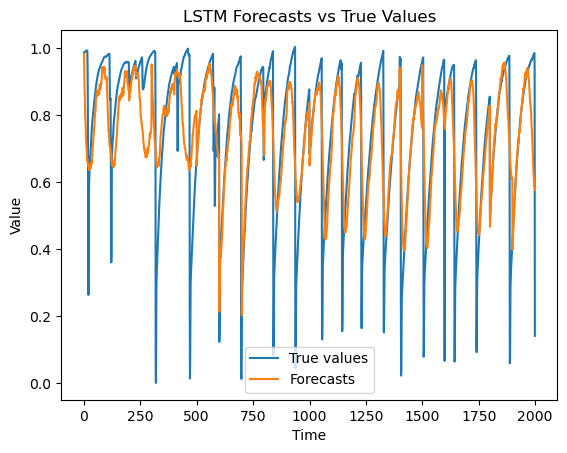

In [15]:
plt.plot(y_test_sc_skip, label="True values")
plt.plot(y_pred_sc_skip, label="Forecasts")

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("LSTM Forecasts vs True Values")
plt.show()